In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm

In [5]:
torch.cuda.empty_cache()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## Preprocess the data

In [7]:
data = pd.read_csv('../data/xau_usd_5m.csv')

data.head()

,datetime,open,high,low,close,volume
0,2020-02-02 23:00:00,1591.197998,1591.197998,1587.751953,1588.687012,547
1,2020-02-02 23:05:00,1588.734009,1590.536987,1588.064941,1590.447998,372
2,2020-02-02 23:10:00,1590.500000,1592.167969,1588.849976,1589.462036,606
3,2020-02-02 23:15:00,1589.421997,1590.144043,1588.848999,1589.894043,242
4,2020-02-02 23:20:00,1589.943970,1590.021973,1588.385010,1588.942017,246


In [8]:
# Preprocess the data for RNN

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Select the features and target variable
features = ['open', 'high', 'low', 'close', 'volume']
target_param = 'close'
# Scale the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
# Split the data into training and testing sets
# train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Convert the data to PyTorch tensors
start, end = 0, 1000
train_data = data.iloc[start:end]
train_data_tensor = torch.tensor(train_data[features].values, dtype=torch.float32).to(device)
train_target_tensor = torch.tensor(train_data[target_param].values, dtype=torch.float32).unsqueeze(1).to(device)
# test_data_tensor = torch.tensor(test_data[features].values, dtype=torch.float32).to(device)
# test_target_tensor = torch.tensor(test_data[target_param].values, dtype=torch.float32).unsqueeze(1).to(device)

In [10]:
print(train_data_tensor.shape)
print(train_target_tensor.shape)

torch.Size([1000, 5])
torch.Size([1000, 1])


## Define the RNN model

In [11]:
class Rnn(nn.Module):
    def __init__(self, input_size, rnn_size):
        super(Rnn, self).__init__()
        self.rnn = nn.RNN(input_size, rnn_size, batch_first=True)

    def forward(self, x):
        out, _ = self.rnn(x)
        return out
    
    def predict(self, x):
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            out = self.forward(x)
            return out.squeeze(0).numpy()

In [13]:
class RnnForce:
    def __init__(self, input_size, rnn_size, output_size, device:torch.device, ridge_reg:float=0.01, lambda_:float=0.99):
        self.rnn = Rnn(input_size, rnn_size)
        self.device = device
        
        # RLS params
        self.dec = torch.zeros(rnn_size, output_size, device=device)
        self.Pinv = torch.eye(rnn_size, device=device) * ridge_reg
        self.lambda_ = lambda_
        self.rnn_size = rnn_size
        self.output_size = output_size
        self.input_size = input_size
        
        
    def rls(self, x, y):
        # RLS update
        x = x.view(-1, self.rnn_size)
        y = y.view(-1, self.output_size)
        
        # Compute the Kalman gain
        u = self.Pinv @ x.T
        K = u / (self.lambda_ + x @ u)
        # Update the inverse covariance matrix
        self.Pinv = (self.Pinv - K @ x @ self.Pinv) / self.lambda_
        # Update the weights
        self.dec = self.dec + K @ (y - x @ self.dec)
        
    def train(self, x, y):
        # Forward pass
        x = x.view(-1, self.input_size)
        out = self.rnn(x)
        # RLS update
        self.rls(out, y)
    
    def predict(self, x):
        # Forward pass
        x = x.view(-1, 1, self.input_size)
        # Get the RNN output
        out = self.rnn(x)
        # Compute the prediction
        y_pred = out @ self.dec
        return y_pred.squeeze(0).detach().numpy()
        

In [ ]:
# Train the RNN model
input_size = len(features)
rnn_size = 1000
output_size = 1
rnnf = RnnForce(input_size, rnn_size, output_size, device=device, ridge_reg=0.01, lambda_=0.99)

# Train the model on the training set
preds_on_train = []
for i in tqdm(range(train_data_tensor.shape[0])):
    x = train_data_tensor[i]
    y = train_target_tensor[i]
    rnnf.train(x, y)
    
    # Predict the next value
    y_pred = rnnf.predict(x)
    preds_on_train.append(y_pred)

preds_on_train_arr = np.array(preds_on_train)

100%|██████████| 1000/1000 [02:06<00:00,  7.90it/s]


In [22]:
preds_on_train_arr = preds_on_train_arr.reshape(-1, 1)

# preds_on_train_arr_unscaled = scaler.inverse_transform(preds_on_train_arr)
# train_target_tensor_unscaled = scaler.inverse_transform(train_target_tensor.cpu().numpy())

In [24]:
# Compute the RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(train_target_tensor.numpy(), preds_on_train_arr))
print(f'Training RMSE: {rmse_train:.4f}')

Training RMSE: 0.0183


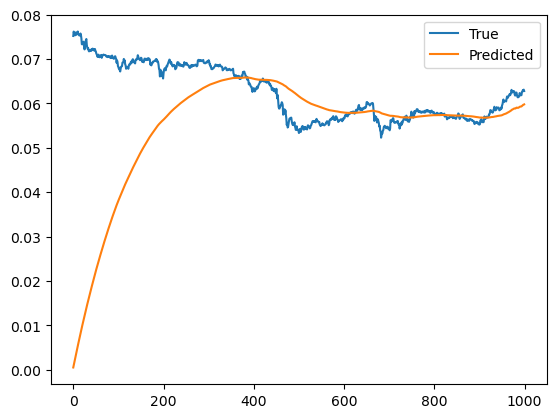

In [25]:
plt.plot(train_target_tensor.cpu().numpy(), label='True')
plt.plot(preds_on_train_arr, label='Predicted')
plt.legend()
plt.show()